## Adding in covariates

Now that we extracted the other covariates and interpolated them to the same frequency, we can combine them with the prior clean dataframe that had only diabetes and obesity prevalence as covariates.

In [2]:
%%bash
ls ../data/pickles

MI_mortality_medicaid_expansion.pkl
any_exercise_list_of_dfs.pkl
cardiac_mortality_obesity_dm_df_by_state.pkl
codebook_dfs_dict.pkl
consensus_var_desc_dict.pkl
dict_of_interpol_covariate_state_dfs.pkl
dict_of_relevant_dfs_raw.pkl
interpol_truncated_MI_mortality_per_state_dict.pkl
list_of_relevant_dfs_raw.pkl
master_codebook_all_years.pkl
myocardial_infarction_df_state_mortality_dict.pkl
state_population_by_year_dict.pkl


In [171]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from progress_bar import log_progress

import matplotlib.pyplot as plt

import pickle
import itertools

%matplotlib inline

In [44]:
# my own helper functions
import sarimax_helper_functions
from sarimax_helper_functions import evaluate_arimax_model_using_forecasting, evaluate_arimax_model_using_prediction, get_test_forecast_from_arimax_with_params, get_test_prediction_from_arimax_with_params, make_arimax_model_with_params, make_all_possible_param_dictionaries

In [4]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "rb") as picklefile:
    MI_mortality_per_state_dict = pickle.load(picklefile)

In [5]:
with open("../data/pickles/dict_of_interpol_covariate_state_dfs.pkl", "rb") as picklefile:
    state_covariate_dfs_dict = pickle.load(picklefile)

In [6]:
MI_mortality_per_state_dict['Alabama'].head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,332.0,61.400000,7.400000,4430141.00,7.494118
1999-02-01,332.0,60.833333,7.383333,4431554.25,7.491728
1999-03-01,377.0,60.266667,7.366667,4432967.50,8.504461
1999-04-01,301.0,59.700000,7.350000,4434380.75,6.787870
1999-05-01,314.0,59.133333,7.333333,4435794.00,7.078778


In [7]:
state_covariate_dfs_dict['Alabama'].head()

,high_cholesterol,hypertension,exercise,general_health,mental_health,coverage,income,smoker,med_cost,gender
year,,,,,,,,,,
1999-01-01,0.235488,0.310615,0.296199,0.183570,3.523735,0.150268,33.889522,0.233701,0.114934,0.470428
1999-02-01,0.235964,0.310842,0.297831,0.184316,3.511476,0.151162,34.168322,0.235205,0.115571,0.470527
1999-03-01,0.236440,0.311069,0.299463,0.185062,3.499217,0.152057,34.447122,0.236709,0.116208,0.470626
1999-04-01,0.236916,0.311297,0.301095,0.185808,3.486958,0.152951,34.725921,0.238212,0.116845,0.470726
1999-05-01,0.237393,0.311524,0.302726,0.186554,3.474699,0.153845,35.004721,0.239716,0.117482,0.470825


In [8]:
x = MI_mortality_per_state_dict['Alabama']
z = state_covariate_dfs_dict['Alabama']

In [39]:
master_dict_of_state_dfs = {}

for state, df in MI_mortality_per_state_dict.items():
    covariate_df = state_covariate_dfs_dict[state]
    temp_df = pd.merge(df, covariate_df, left_index=True, right_index=True)
    temp_df = temp_df.drop(columns=['Deaths', 'Population'])
    master_dict_of_state_dfs[state] = temp_df

I now have a dictionary where each state is a key, and the value is a dataframe with the target `mortality_per_100k` and all of the covariates/exogenous variables/predictors. I can now either choose to run SARIMA models vs SARIMAX models vs other models on each of these states, and it would be interesting to compare whether or not adding in the regressors actually improves accuracy at all.

In [221]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [222]:
param_choices = {}
param_choices['order'] = pdq
param_choices['seasonal'] = seasonal_pdq
param_choices['trend'] = ['c', 'ct', 't']
param_choices['enforce_stationarity'] = [False]
param_choices['enforce_invertibility'] = [False]

In [223]:
list_of_SARIMA_dicts = make_all_possible_param_dictionaries(param_choices=param_choices)

In [224]:
list_of_SARIMA_dicts2 = make_all_possible_param_dictionaries(param_choices=param_choices)

In [225]:
len(list_of_SARIMA_dicts2)

192

In [49]:
target = master_dict_of_state_dfs['California']

In [50]:
comparison_list_forecasting = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, target.mortality_per_100k)
    comparison_list_forecasting.append((index, aic, test_rmse))

In [51]:
parameter_gridsearch_df = pd.DataFrame(comparison_list_forecasting, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
parameter_gridsearch_df.set_index('parameter_dict_number', inplace=True)

In [ ]:
comparison_list_forecasting_exog = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, target.mortality_per_100k, 0.66, target.drop(columns=['mortality_per_100k']))
    comparison_list_forecasting_exog.append((index, aic, test_rmse))

In [226]:
comparison_list_forecasting_exog = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts2), every=1, size=len(list_of_SARIMA_dicts2)):
    aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, target.mortality_per_100k, 0.66, target.drop(columns=['mortality_per_100k']))
    comparison_list_forecasting_exog.append((index, aic, test_rmse))

In [231]:
parameter_gridsearch_exog = pd.DataFrame(comparison_list_forecasting_exog, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
parameter_gridsearch_exog.set_index('parameter_dict_number', inplace=True)

In [235]:
parameter_gridsearch_exog.sort_values(by='forecast_test_mse').head()

,aic,forecast_test_mse
parameter_dict_number,,
80,56.183515,0.435625
152,65.524946,0.480471
190,-4.373594,0.520554
176,57.436513,0.526235
113,-16.060521,0.535293


In [237]:
list_of_SARIMA_dicts[80]

{'order': (0, 1, 1),
 'seasonal': (0, 1, 0, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

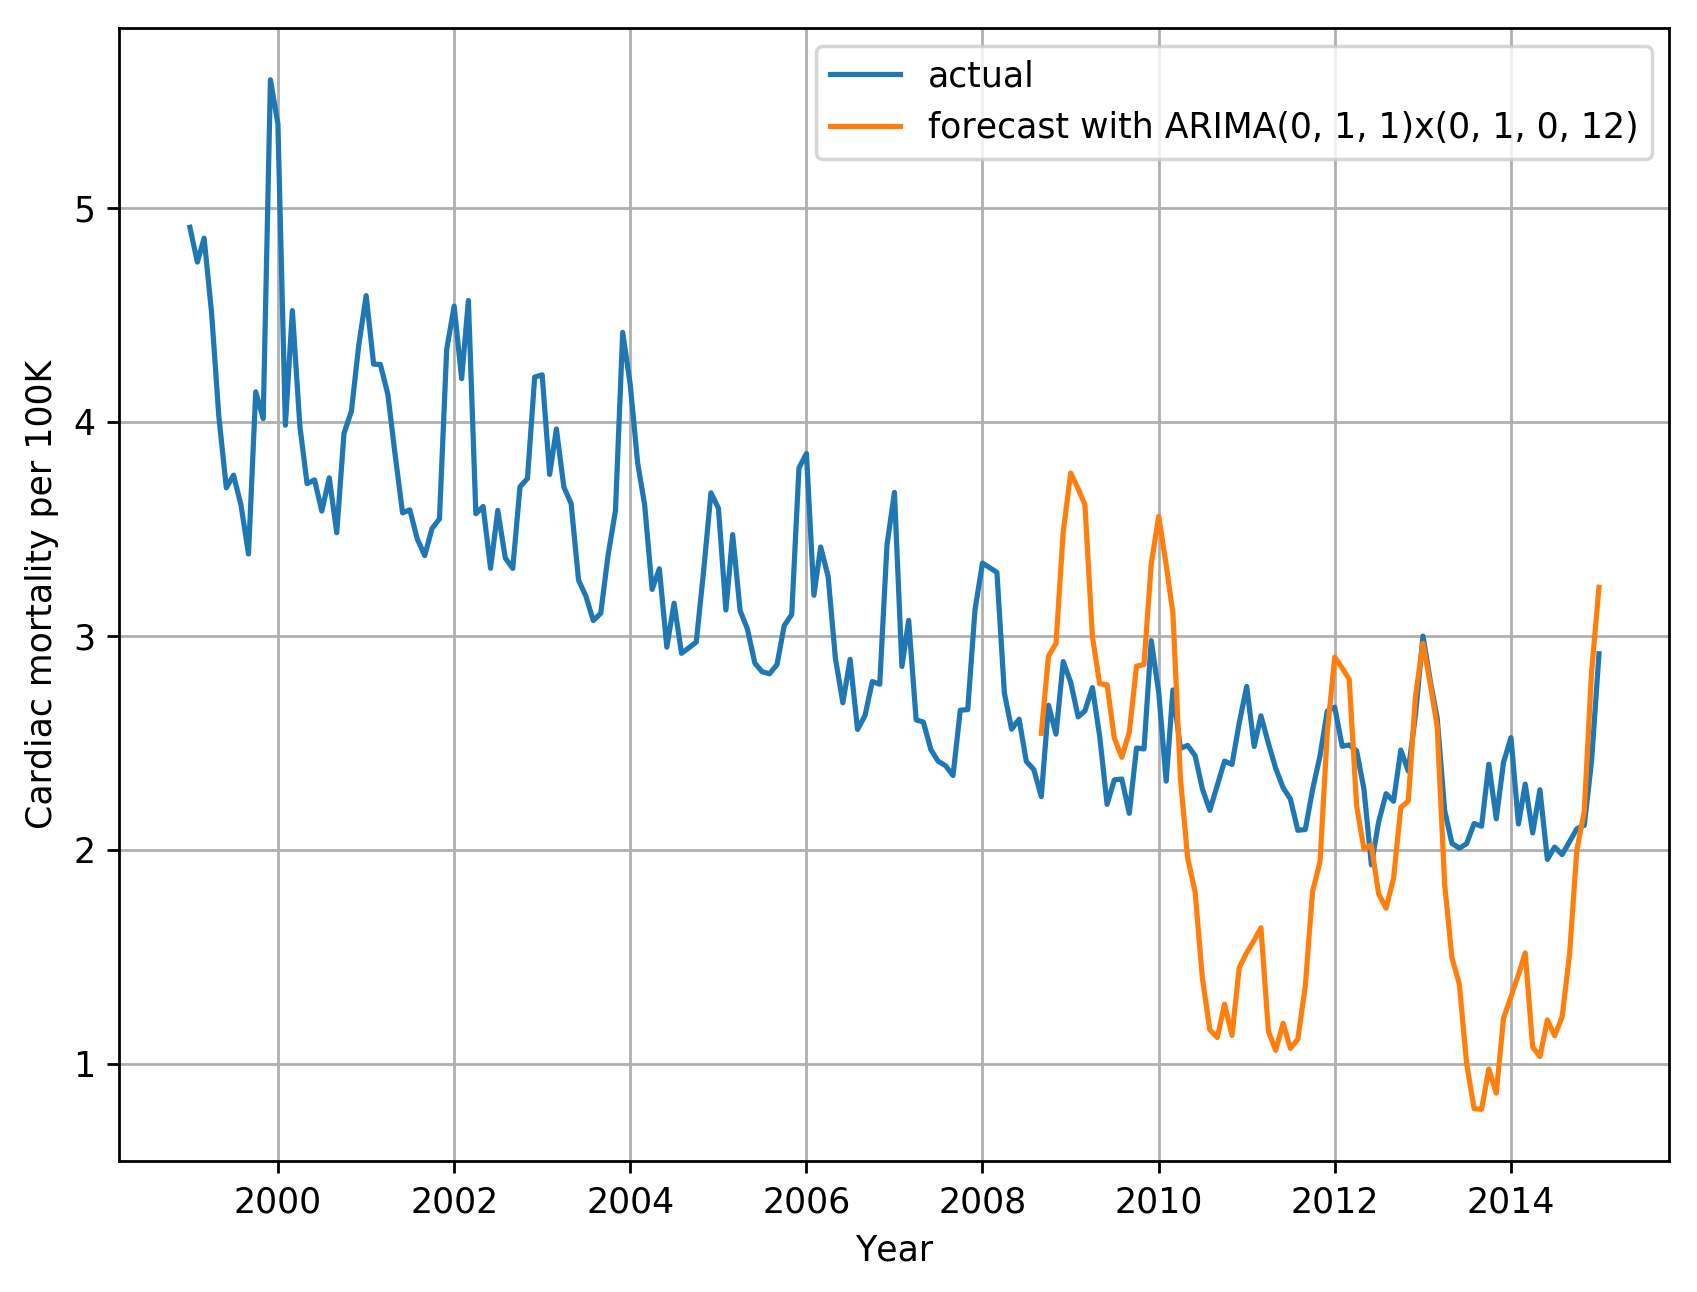

In [241]:
dict_num = 80

california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[dict_num], target.mortality_per_100k, train_fraction=0.6, exog_var=target.drop(columns=['mortality_per_100k']))

plt.plot(target.mortality_per_100k, label="actual")
plt.plot(california_forecast, label=f"forecast with ARIMA{list_of_SARIMA_dicts[dict_num]['order']}x{list_of_SARIMA_dicts[dict_num]['seasonal']}")

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")

plt.grid()
plt.legend()


plt.savefig("../figures/california_forecast_ARIMAX_10y_with_cov.png")

plt.show()

In [184]:
parameter_gridsearch_exog_df_05 = pd.DataFrame(comparison_list_forecasting_exog, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
parameter_gridsearch_exog_df_05.set_index('parameter_dict_number', inplace=True)

In [185]:
with open("parameter_gridsearch_exog_df_05.pkl", "wb") as f:
    pickle.dump(parameter_gridsearch_exog_df_05, f)

In [186]:
parameter_gridsearch_exog_df_05.sort_values(by='forecast_test_mse').head()

,aic,forecast_test_mse
parameter_dict_number,,
87,9.563590,0.273745
152,61.303528,0.301681
86,46.476972,0.306853
117,-26.369460,0.319988
47,-26.787262,0.326724


In [204]:
list_of_SARIMA_dicts2[152]

{'order': (1, 1, 0),
 'seasonal': (0, 1, 0, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

In [187]:
list_of_SARIMA_dicts2[87]

{'order': (0, 1, 1),
 'seasonal': (1, 0, 1, 12),
 'trend': 'c',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

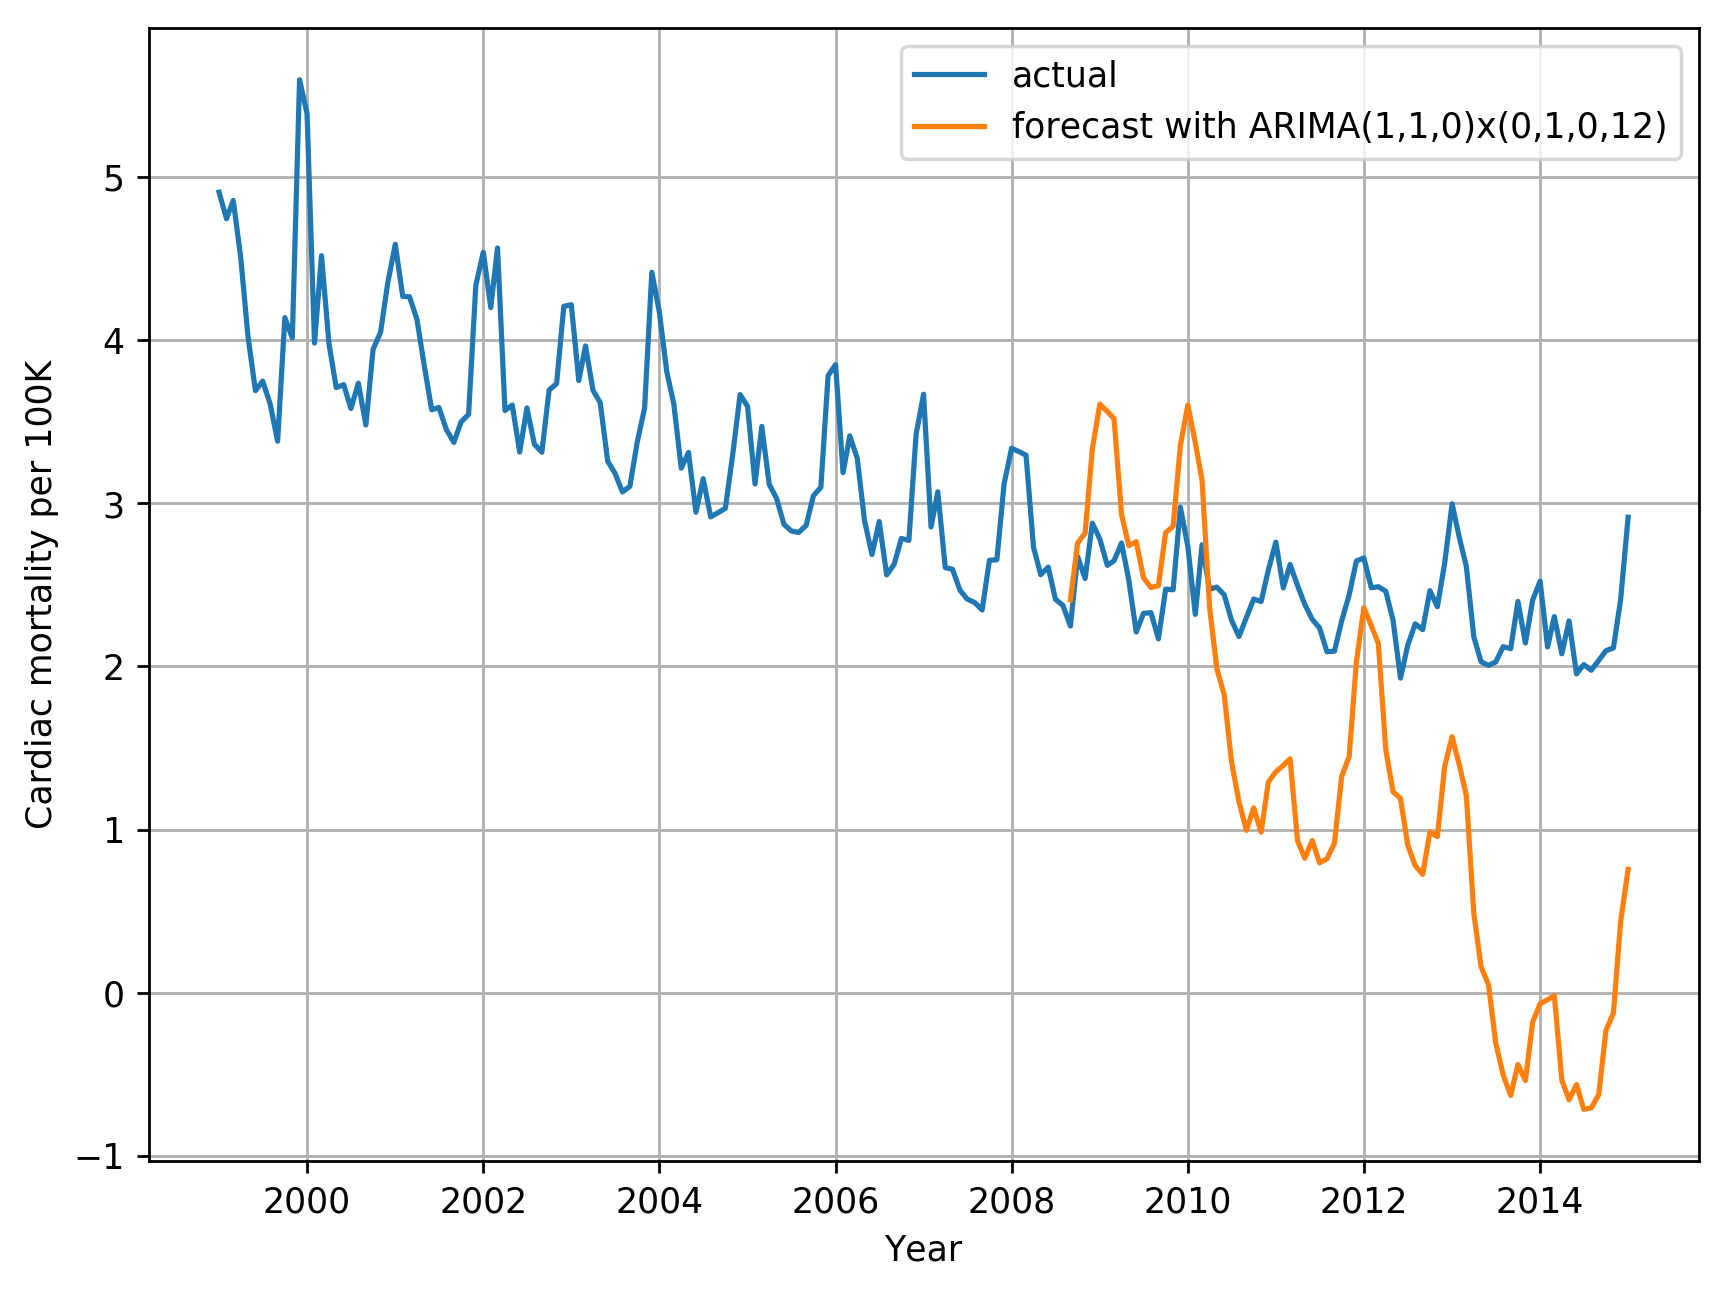

In [217]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts2[152], target.mortality_per_100k, train_fraction=0.6, exog_var=target.drop(columns=['mortality_per_100k']))

plt.plot(target.mortality_per_100k, label="actual")
plt.plot(california_forecast, label="forecast with ARIMA(1,1,0)x(0,1,0,12)")

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")

plt.grid()
plt.legend()

#plt.savefig("../figures/california_forecast_ARIMAX_10y_with_cov.png")

plt.show()

In [157]:
with open("parameter_gridsearch_df_exog_df_list_of_sarima_dicts.pkl", "wb") as f:
    pickle.dump((parameter_gridsearch_df, parameter_gridsearch_exog_df, list_of_SARIMA_dicts), f)

In [57]:
parameter_gridsearch_exog_df.sort_values(by='forecast_test_mse').head()

,aic,forecast_test_mse
parameter_dict_number,,
1717,-14.563540,0.318737
920,29.556151,0.339513
1155,40.125010,0.356793
345,45.242454,0.364118
1722,55.282913,0.364728


In [58]:
parameter_gridsearch_df.sort_values(by='forecast_test_mse').head()

,aic,forecast_test_mse
parameter_dict_number,,
2085,-40.035857,0.139960
1650,-44.855902,0.143879
1007,-34.393129,0.144501
921,-45.360703,0.145396
1488,-48.837934,0.145614


In [60]:
list_of_SARIMA_dicts[920]

{'order': (1, 0, 2),
 'seasonal': (1, 0, 0, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

In [79]:
list_of_SARIMA_dicts[1717]

{'order': (2, 1, 0),
 'seasonal': (0, 1, 2, 12),
 'trend': 'ct',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

Now, let's try using the other types of models on the dataframes, and see what the test MSE is with the other models.

In [110]:
evaluate_arimax_model_using_forecasting(list_of_SARIMA_dicts[1717], y, 0.66, X)

(-14.563540491725881, 0.3187368042022111)

In [173]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1717], target.mortality_per_100k, train_fraction=0.66, exog_var=target.drop(columns=['mortality_per_100k']))

In [168]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[920], target.mortality_per_100k, train_fraction=0.66, exog_var=target.drop(columns=['mortality_per_100k']))

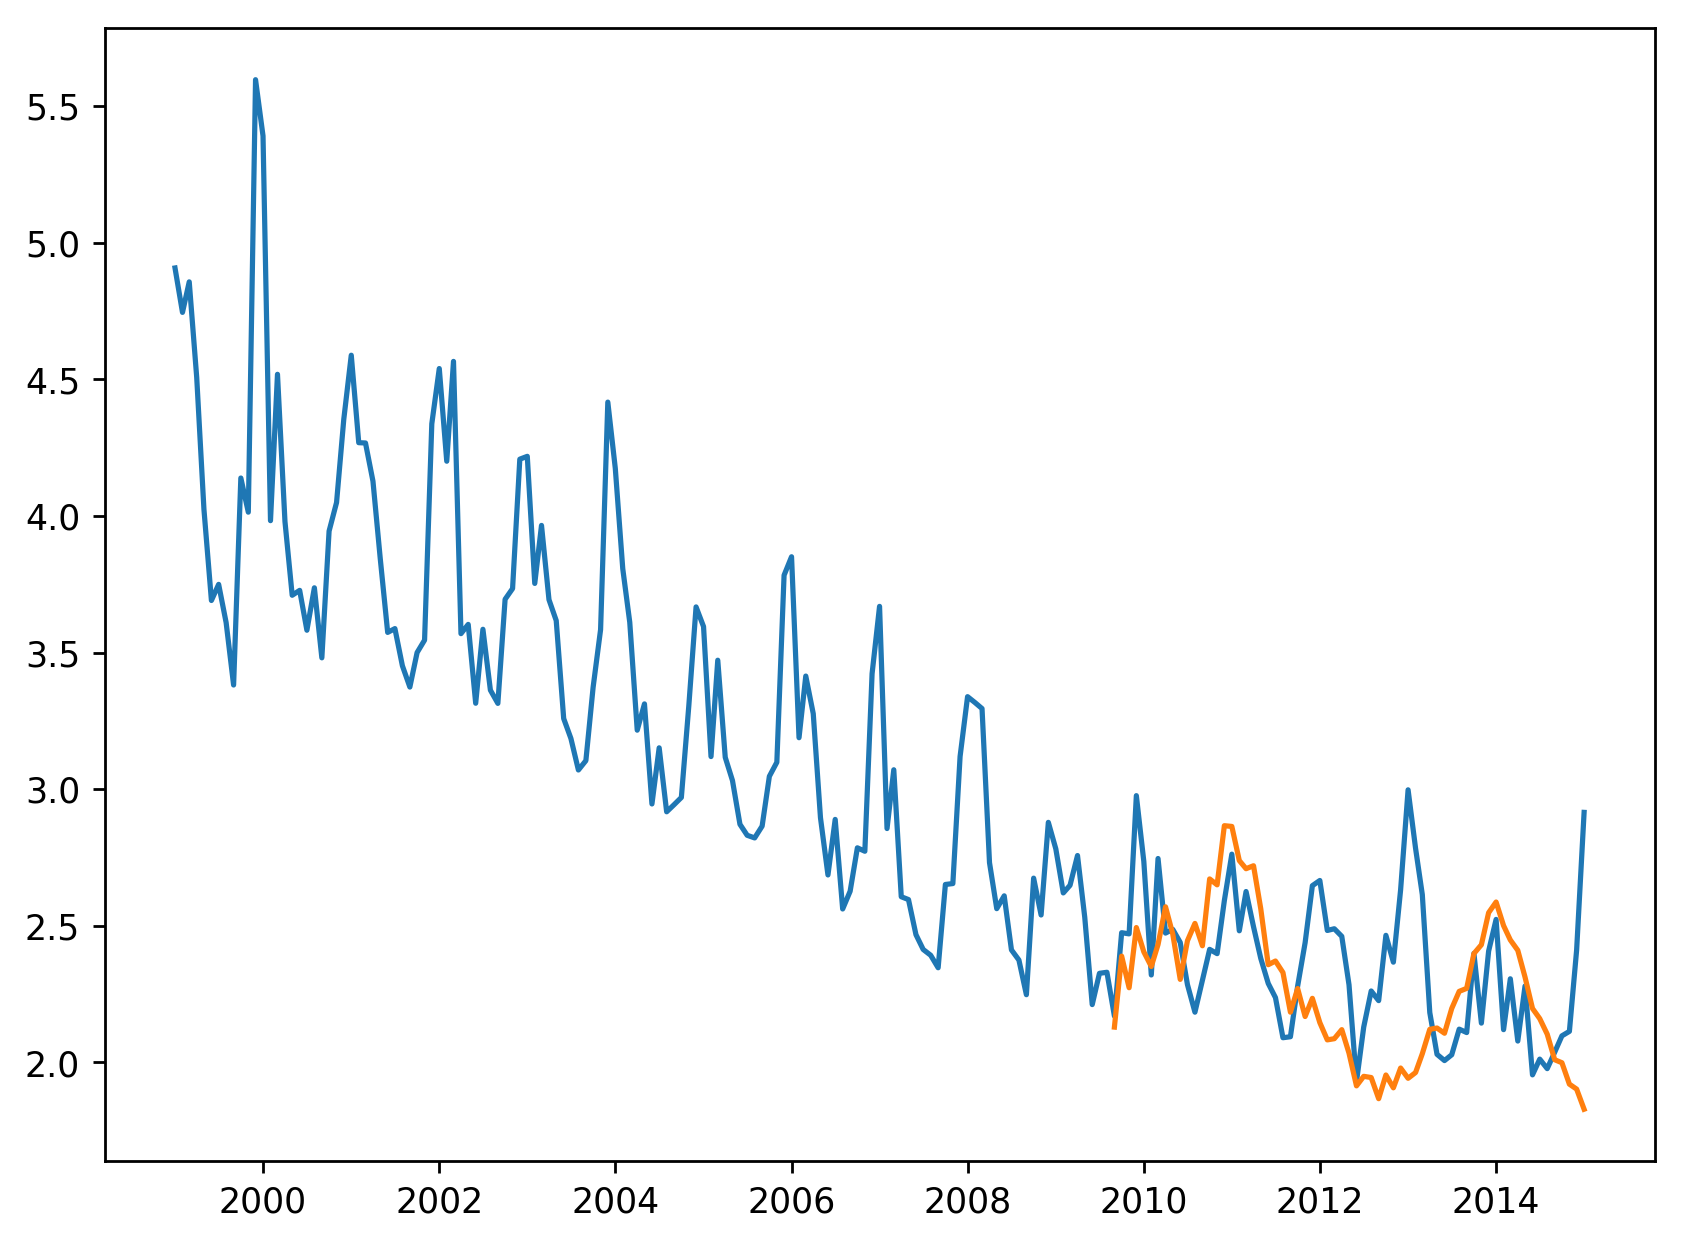

In [172]:
plt.plot(target.mortality_per_100k)

plt.plot(california_forecast, label="forecast with ")

Now, let's try shuffling each of the covariates and seeing which one decreases the test MSE the most. This will potentially give us some sense of which covariate is actually contributing the most to the model? It might also be interesting to see how the prediction changes if we change different covariates to different values.

In [135]:
def scramble_column(col, df):
    temp_df = df.copy()
    scramble_col = list(temp_df[col].sample(len(temp_df[col])))
    # we have to cast this as a list; sampling does scramble the records, but they retain their index, and so
    # when you set col equal to scamble col, it matches the values by index. Making it a list removes the index.
    temp_df[col] = scramble_col
    return temp_df

In [136]:
y = target.mortality_per_100k
X = target.drop(columns=['mortality_per_100k'])

In [137]:
# Without scrambling columns:
y_pred = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1717], y, train_fraction=0.66, exog_var=X)
y_test = y[y_pred.index]
    
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

0.3187368042022111


In [138]:
X.obesity_prevalence.head()

1999-01-01    41.500000
1999-02-01    41.308333
1999-03-01    41.116667
1999-04-01    40.925000
1999-05-01    40.733333
Name: obesity_prevalence, dtype: float64

In [143]:
z = scramble_column('obesity_prevalence', X)

In [144]:
z.obesity_prevalence.head()

1999-01-01    45.083333
1999-02-01    45.625000
1999-03-01    45.616667
1999-04-01    47.950000
1999-05-01    46.266667
Name: obesity_prevalence, dtype: float64

In [145]:
# Now, we iterate through each column and scramble them, and run the model and forecast.
scramble_var_rmse_dict = {}

for col in X.columns:
    print(f"Scrambling {col}.")
    scramble_df = scramble_column(col, X)
    
    y_pred = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1717], y, train_fraction=0.66, exog_var=scramble_df)
    y_test = y[y_pred.index]
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE is: {rmse}")
    scramble_var_rmse_dict[col] = rmse

Scrambling obesity_prevalence.
RMSE is: 1.8568337644494304
Scrambling diabetes_prevalence.
RMSE is: 1.8965925578143936
Scrambling high_cholesterol.
RMSE is: 4.238252807637884
Scrambling hypertension.
RMSE is: 7.219598086327871
Scrambling exercise.
RMSE is: 2.721611539237737
Scrambling general_health.
RMSE is: 1.9537463573078873
Scrambling mental_health.
RMSE is: 2.9634948237568093
Scrambling coverage.
RMSE is: 1.750859633507267
Scrambling income.
RMSE is: 3.4355445507125832
Scrambling smoker.
RMSE is: 1.4384466148886481
Scrambling med_cost.
RMSE is: 4.918782083547428
Scrambling gender.
RMSE is: 2.1578168069962538


In [154]:
scramble_var_rmse_df = pd.DataFrame({"var_name": list(scramble_var_rmse_dict.keys()), "increase_in_RMSE": list(scramble_var_rmse_dict.values())})

In [156]:
scramble_var_rmse_df.sort_values(by='increase_in_RMSE', ascending=False)

,var_name,increase_in_RMSE
3,hypertension,7.219598
10,med_cost,4.918782
2,high_cholesterol,4.238253
8,income,3.435545
6,mental_health,2.963495
4,exercise,2.721612
11,gender,2.157817
5,general_health,1.953746
1,diabetes_prevalence,1.896593
0,obesity_prevalence,1.856834
